# Importing Libraries

In [ ]:
seed_value= 0

import torch, torchvision
import glob
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import numpy as np
np.random.seed(seed_value)
import cv2
import random
random.seed(seed_value)
import itertools
import pandas as pd
#from tqdm import tqdm
import urllib
import json
import PIL.Image as Image
import shutil
from os.path import exists
from tqdm.auto import  tqdm
import imagehash
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime

from sklearn.metrics import classification_report, confusion_matrix


main_path = "../input/rut-subsidence/Rut+Subsidence/Train/"
path_rut = main_path + 'Rut/'
path_subsidence = main_path + 'Subsidence/'

# Load and visualize the train set

In [ ]:
main_df = pd.DataFrame()
main_df['images'] = os.listdir(path_rut) + os.listdir(path_subsidence)

In [ ]:
classes = []
paths = []
for image in main_df['images']:
    class_ = image.split('_')[0]
#     print(image.split('_'))
#     raise ValueError("None")
#     if class_ == 'Crack':
#         class_+=str('s')
    classes.append(class_)
    paths.append(main_path+class_+'/'+image)

In [ ]:
main_df['classes'] = classes
main_df['path'] = paths

In [ ]:
main_df.tail()

,images,classes,path
281,Subsidence_199.jpg,Subsidence,../input/rut-subsidence/Rut+Subsidence/Train/S...
282,Subsidence_171.jpg,Subsidence,../input/rut-subsidence/Rut+Subsidence/Train/S...
283,Subsidence_117.jpg,Subsidence,../input/rut-subsidence/Rut+Subsidence/Train/S...
284,Subsidence_121.jpg,Subsidence,../input/rut-subsidence/Rut+Subsidence/Train/S...
285,Subsidence_31.jpg,Subsidence,../input/rut-subsidence/Rut+Subsidence/Train/S...


In [ ]:
def plot_species(df,defect_name):
    plt.figure(figsize = (12,12))
    species_df = df[df['classes'] == defect_name].reset_index(drop = True)
    plt.suptitle(defect_name)
    for idx,i in enumerate(np.random.choice(species_df['path'],32)):
        plt.subplot(8,8,idx+1)
        image_path = i
        img = Image.open(image_path)
        img = img.resize((224,224))
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

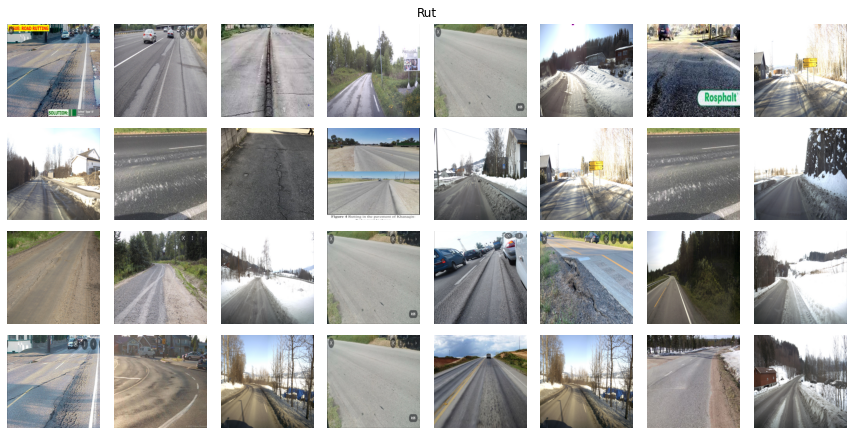

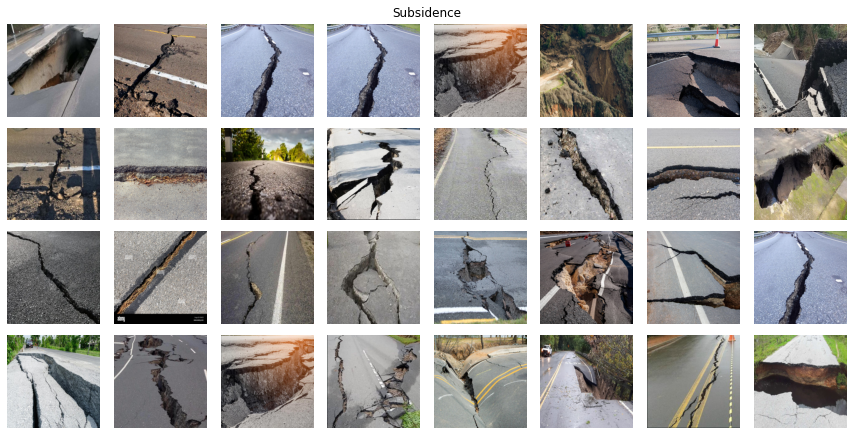

In [ ]:
for defect_name in main_df['classes'].unique():
    plot_species(main_df , defect_name)

In [ ]:
class_names = sorted(os.listdir(main_path))
class_names

['Rut', 'Subsidence']

In [ ]:
n_classes = len(class_names)
print(f"Total Number of Classes : {n_classes}")

Total Number of Classes : 2


In [ ]:
class_dis = [len(os.listdir(main_path + name)) for name in class_names]
class_dis

[143, 143]

In [ ]:
fig = px.pie(names=class_names, values=class_dis)
fig.update_layout({'title':{
    'text':'Class Distribution',
    'x':0.5
}})
fig.show()

# Load the dataset

In [ ]:
train_path = '../input/rut-subsidence/Rut+Subsidence/Train/'
test_path = '../input/rut-subsidence/Rut+Subsidence/Test/'
val_path = '../input/rut-subsidence/Rut+Subsidence/Val/'

train_names = sorted(os.listdir(train_path))
test_names = sorted(os.listdir(test_path))

assert train_names == test_names

n_classes = len(train_names)
print(f"Total Number of Classes : {n_classes}")

Total Number of Classes : 2


In [ ]:
import tensorflow
from tensorflow import keras

# Data 
from keras.preprocessing.image import ImageDataGenerator

# Model 
from keras.models import Sequential, load_model
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout

# Transfer Learning Models 
from tensorflow.keras.applications import InceptionV3, Xception, ResNet152V2, MobileNetV2, InceptionResNetV2

# set random set
tensorflow.random.set_seed(seed_value)

# Callbacks 
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Initialize Generator
train_gen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True, 
    rotation_range=20,
#     validation_split=0.2
)

test_gen = ImageDataGenerator(rescale=1./255)

# Load Data
train_ds = train_gen.flow_from_directory(
    train_path,
    class_mode='binary',
    shuffle=True,
    batch_size=32,
    target_size=(256,256),
#     subset="training"
)

val_ds = test_gen.flow_from_directory(
    val_path,
    class_mode='binary',
    shuffle=False,
    batch_size=32,
    target_size=(256,256),
#     subset="validation"
)

test_ds = test_gen.flow_from_directory(
    test_path,
    class_mode='binary',
    shuffle=False,
    batch_size=32,
    target_size=(256,256),
)

Found 286 images belonging to 2 classes.
Found 72 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


# Train the models

## 1. ResNet152V2

In [ ]:
# Set Name
name = "ResNet152V2"

# Load Pretrained Model
base_model = ResNet152V2(include_top=False, weights='imagenet', input_shape=(256,256,3))
base_model.trainable = False

# Create Model
resnet = Sequential([
    base_model,
    GAP(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
], name=name)

# Compile Model
resnet.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Callbacks
cbs = [
#     EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(name + ".h5", save_best_only=True)
]

# Train Model
hist_resnet = resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=cbs,
)

2022-11-16 04:31:11.573467: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 04:31:11.574605: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 04:31:11.575332: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 04:31:11.576171: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

234561536/234545216 [==============================] - 1s 0us/step


2022-11-16 04:31:25.223768: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-11-16 04:31:35.749970: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


9/9 [==============================] - 40s 3s/step - loss: 0.5746 - accuracy: 0.7098 - val_loss: 0.3766 - val_accuracy: 0.7917


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



Epoch 2/10
9/9 [==============================] - 18s 2s/step - loss: 0.2302 - accuracy: 0.8916 - val_loss: 0.2272 - val_accuracy: 0.9306
Epoch 3/10
9/9 [==============================] - 18s 2s/step - loss: 0.1407 - accuracy: 0.9371 - val_loss: 0.2313 - val_accuracy: 0.9444
Epoch 4/10
9/9 [==============================] - 18s 2s/step - loss: 0.1049 - accuracy: 0.9615 - val_loss: 0.2295 - val_accuracy: 0.9444
Epoch 5/10
9/9 [==============================] - 18s 2s/step - loss: 0.0748 - accuracy: 0.9720 - val_loss: 0.2243 - val_accuracy: 0.9444
Epoch 6/10
9/9 [==============================] - 18s 2s/step - loss: 0.0614 - accuracy: 0.9650 - val_loss: 0.1975 - val_accuracy: 0.9583
Epoch 7/10
9/9 [==============================] - 18s 2s/step - loss: 0.0415 - accuracy: 0.9860 - val_loss: 0.2044 - val_accuracy: 0.9583
Epoch 8/10
9/9 [==============================] - 18s 2s/step - loss: 0.0469 - accuracy: 0.9790 - val_loss: 0.2094 - val_accuracy: 0.9583
Epoch 9/10
9/9 [==================

In [ ]:
model_resnet = load_model('./ResNet152V2.h5')
model_resnet.summary()

Model: "ResNet152V2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 8, 8, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 

In [ ]:
model_resnet.evaluate(test_ds)

2/2 [==============================] - 4s 63ms/step - loss: 0.1672 - accuracy: 0.9250


[0.1671832948923111, 0.925000011920929]

In [ ]:
#Confution Matrix and Classification Report
Y_pred = model_resnet.predict_generator(test_ds, 40 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_ds.classes, y_pred))

print('\nClassification Report')
target_names = ['Rut', 'Subsidence']

print(classification_report(test_ds.classes, y_pred, target_names=target_names))

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



Confusion Matrix
[[17  3]
 [ 0 20]]

Classification Report
              precision    recall  f1-score   support

         Rut       1.00      0.85      0.92        20
  Subsidence       0.87      1.00      0.93        20

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.93      0.93      0.92        40



### The test results for ResNet152V2:
* Accuracy: **92-95%**
* F1 score: **92-95%**
* Precision: **92-95%**
* Recall: **92-95%**

## 2. Xception

In [ ]:
# Set Name
name = "Xception"

# Load Pretrained Model
base_model = Xception(include_top=False, weights='imagenet', input_shape=(256,256,3))
base_model.trainable = False

# Create Model
xception = Sequential([
    base_model,
    GAP(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
], name=name)

# Compile Model
xception.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Callbacks
cbs = [
#     EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(name + ".h5", save_best_only=True)
]

# Train Model
hist_xception = xception.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=cbs
)

83697664/83683744 [==============================] - 0s 0us/step
Epoch 1/10
9/9 [==============================] - 23s 2s/step - loss: 0.4957 - accuracy: 0.7483 - val_loss: 0.3103 - val_accuracy: 0.8611


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



Epoch 2/10
9/9 [==============================] - 18s 2s/step - loss: 0.2344 - accuracy: 0.9126 - val_loss: 0.2449 - val_accuracy: 0.9028
Epoch 3/10
9/9 [==============================] - 18s 2s/step - loss: 0.1502 - accuracy: 0.9371 - val_loss: 0.2468 - val_accuracy: 0.9167
Epoch 4/10
9/9 [==============================] - 18s 2s/step - loss: 0.0951 - accuracy: 0.9685 - val_loss: 0.2405 - val_accuracy: 0.9028
Epoch 5/10
9/9 [==============================] - 18s 2s/step - loss: 0.1061 - accuracy: 0.9336 - val_loss: 0.2492 - val_accuracy: 0.9167
Epoch 6/10
9/9 [==============================] - 18s 2s/step - loss: 0.1161 - accuracy: 0.9615 - val_loss: 0.3079 - val_accuracy: 0.9028
Epoch 7/10
9/9 [==============================] - 18s 2s/step - loss: 0.0951 - accuracy: 0.9790 - val_loss: 0.2713 - val_accuracy: 0.9028
Epoch 8/10
9/9 [==============================] - 18s 2s/step - loss: 0.0764 - accuracy: 0.9720 - val_loss: 0.2919 - val_accuracy: 0.9028
Epoch 9/10
9/9 [==================

In [ ]:
model_xception = load_model('./Xception.h5')
model_xception.summary()

Model: "Xception"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 514

In [ ]:
model_xception.evaluate(test_ds)

2/2 [==============================] - 2s 31ms/step - loss: 0.1392 - accuracy: 0.9250


[0.13915123045444489, 0.925000011920929]

In [ ]:
#Confution Matrix and Classification Report
Y_pred = model_xception.predict_generator(test_ds, 40 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_ds.classes, y_pred))

print('\nClassification Report')
target_names = ['Rut', 'Subsidence']

print(classification_report(test_ds.classes, y_pred, target_names=target_names))

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



Confusion Matrix
[[18  2]
 [ 1 19]]

Classification Report
              precision    recall  f1-score   support

         Rut       0.95      0.90      0.92        20
  Subsidence       0.90      0.95      0.93        20

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.93      0.93      0.92        40



### The test results for Xception:
* Accuracy: **92-94%**
* F1 score: **92-94%**
* Precision: **92-94%**
* Recall: **92-94%**

## 3. InceptionV3

In [ ]:
# Set Name
name = "InceptionV3"

# Load Pretrained Model
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(256,256,3))
base_model.trainable = False

# Create Model
inception = Sequential([
    base_model,
    GAP(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
], name=name)

# Compile Model
inception.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Callbacks
cbs = [
#     EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(name + ".h5", save_best_only=True)
]

# Train Model
hist_inception = inception.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=cbs
)

87924736/87910968 [==============================] - 1s 0us/step
Epoch 1/10
9/9 [==============================] - 26s 3s/step - loss: 0.9517 - accuracy: 0.5559 - val_loss: 0.4170 - val_accuracy: 0.8333
Epoch 2/10
9/9 [==============================] - 18s 2s/step - loss: 0.4382 - accuracy: 0.7937 - val_loss: 0.4217 - val_accuracy: 0.8472
Epoch 3/10
9/9 [==============================] - 18s 2s/step - loss: 0.2571 - accuracy: 0.8951 - val_loss: 0.3472 - val_accuracy: 0.8611
Epoch 4/10
9/9 [==============================] - 17s 2s/step - loss: 0.2420 - accuracy: 0.9021 - val_loss: 0.3094 - val_accuracy: 0.8889
Epoch 5/10
9/9 [==============================] - 18s 2s/step - loss: 0.2305 - accuracy: 0.9091 - val_loss: 0.2931 - val_accuracy: 0.8889
Epoch 6/10
9/9 [==============================] - 17s 2s/step - loss: 0.1675 - accuracy: 0.9336 - val_loss: 0.2779 - val_accuracy: 0.8611
Epoch 7/10
9/9 [==============================] - 18s 2s/step - loss: 0.1366 - accuracy: 0.9441 - val_loss:

In [ ]:
model_inception = load_model('./InceptionV3.h5')
model_inception.summary()

Model: "InceptionV3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 

In [ ]:
model_inception.evaluate(test_ds)

2/2 [==============================] - 3s 40ms/step - loss: 0.1906 - accuracy: 0.9500


[0.19058255851268768, 0.949999988079071]

In [ ]:
#Confution Matrix and Classification Report
Y_pred = model_inception.predict_generator(test_ds, 40 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_ds.classes, y_pred))

print('\nClassification Report')
target_names = ['Rut', 'Subsidence']

print(classification_report(test_ds.classes, y_pred, target_names=target_names))

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



Confusion Matrix
[[18  2]
 [ 0 20]]

Classification Report
              precision    recall  f1-score   support

         Rut       1.00      0.90      0.95        20
  Subsidence       0.91      1.00      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



### The test results for InceptionV3:
* Accuracy: **94-95%**
* F1 score: **94-95%**
* Precision: **94-95%**
* Recall: **94-95%**

## 4. MobileNetV2 
(for embedded deployment)

In [ ]:
# Set Name
name = "MobileNetV2"

# Load Pretrained Model
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(256,256,3))
base_model.trainable = False

# Create Model
mobilenet = Sequential([
    base_model,
    GAP(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
], name=name)

# Compile Model
mobilenet.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Callbacks
cbs = [
#     EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(name + ".h5", save_best_only=True)
]

# Train Model
hist_mobilenet = mobilenet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=cbs
)

9420800/9406464 [==============================] - 0s 0us/step
Epoch 1/10
9/9 [==============================] - 23s 2s/step - loss: 0.6051 - accuracy: 0.7378 - val_loss: 0.2994 - val_accuracy: 0.8194


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



Epoch 2/10
9/9 [==============================] - 18s 2s/step - loss: 0.3057 - accuracy: 0.8636 - val_loss: 0.2761 - val_accuracy: 0.8472
Epoch 3/10
9/9 [==============================] - 17s 2s/step - loss: 0.1775 - accuracy: 0.9056 - val_loss: 0.2675 - val_accuracy: 0.9028
Epoch 4/10
9/9 [==============================] - 18s 2s/step - loss: 0.1413 - accuracy: 0.9476 - val_loss: 0.2358 - val_accuracy: 0.9028
Epoch 5/10
9/9 [==============================] - 17s 2s/step - loss: 0.0907 - accuracy: 0.9615 - val_loss: 0.2276 - val_accuracy: 0.9167
Epoch 6/10
9/9 [==============================] - 18s 2s/step - loss: 0.0670 - accuracy: 0.9755 - val_loss: 0.2235 - val_accuracy: 0.9028
Epoch 7/10
9/9 [==============================] - 17s 2s/step - loss: 0.0678 - accuracy: 0.9790 - val_loss: 0.2884 - val_accuracy: 0.9028
Epoch 8/10
9/9 [==============================] - 17s 2s/step - loss: 0.0315 - accuracy: 0.9860 - val_loss: 0.3049 - val_accuracy: 0.9028
Epoch 9/10
9/9 [==================

In [ ]:
model_mobilenet = load_model('./MobileNetV2.h5')
model_mobilenet.summary()

Model: "MobileNetV2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               327936    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 

In [ ]:
model_mobilenet.evaluate(test_ds)

2/2 [==============================] - 2s 45ms/step - loss: 0.0517 - accuracy: 0.9750


[0.05166584998369217, 0.9750000238418579]

In [ ]:
#Confution Matrix and Classification Report
Y_pred = model_mobilenet.predict_generator(test_ds, 40 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_ds.classes, y_pred))

print('\nClassification Report')
target_names = ['Rut', 'Subsidence']

print(classification_report(test_ds.classes, y_pred, target_names=target_names))

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



Confusion Matrix
[[19  1]
 [ 0 20]]

Classification Report
              precision    recall  f1-score   support

         Rut       1.00      0.95      0.97        20
  Subsidence       0.95      1.00      0.98        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



### The test results for MobileNetV2:
* Accuracy: **96-98%**
* F1 score: **96-98%**
* Precision: **96-98%**
* Recall: **96-98%**

## 5. InceptionResNetV2

In [ ]:
# Set Name
name = "InceptionResNetV2"

# Load Pretrained Model
base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(256,256,3))
base_model.trainable = False

# Create Model
inceptionresnet = Sequential([
    base_model,
    GAP(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
], name=name)

# Compile Model
inceptionresnet.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Callbacks
cbs = [
#     EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(name + ".h5", save_best_only=True)
]

# Train Model
hist_inceptionresnet = inceptionresnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=cbs
)

219070464/219055592 [==============================] - 1s 0us/step
Epoch 1/10
9/9 [==============================] - 32s 3s/step - loss: 0.6649 - accuracy: 0.7098 - val_loss: 0.2062 - val_accuracy: 0.9306
Epoch 2/10
9/9 [==============================] - 18s 2s/step - loss: 0.3402 - accuracy: 0.8392 - val_loss: 0.1912 - val_accuracy: 0.9167
Epoch 3/10
9/9 [==============================] - 18s 2s/step - loss: 0.3512 - accuracy: 0.8601 - val_loss: 0.3487 - val_accuracy: 0.8611
Epoch 4/10
9/9 [==============================] - 18s 2s/step - loss: 0.2270 - accuracy: 0.9161 - val_loss: 0.2540 - val_accuracy: 0.9028
Epoch 5/10
9/9 [==============================] - 18s 2s/step - loss: 0.1947 - accuracy: 0.9336 - val_loss: 0.1617 - val_accuracy: 0.9167
Epoch 6/10
9/9 [==============================] - 18s 2s/step - loss: 0.1474 - accuracy: 0.9371 - val_loss: 0.2145 - val_accuracy: 0.9583
Epoch 7/10
9/9 [==============================] - 17s 2s/step - loss: 0.1640 - accuracy: 0.9406 - val_los

In [ ]:
model_inceptionresnet = load_model('./InceptionResNetV2.h5')
model_inceptionresnet.summary()

Model: "InceptionResNetV2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 6, 6, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1536)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               393472    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)           

In [ ]:
model_inceptionresnet.evaluate(test_ds)

2/2 [==============================] - 4s 62ms/step - loss: 0.1393 - accuracy: 0.9250


[0.13931645452976227, 0.925000011920929]

In [ ]:
#Confution Matrix and Classification Report
Y_pred = model_inceptionresnet.predict_generator(test_ds, 40 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_ds.classes, y_pred))

print('\nClassification Report')
target_names = ['Rut', 'Subsidence']

print(classification_report(test_ds.classes, y_pred, target_names=target_names))

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



Confusion Matrix
[[18  2]
 [ 1 19]]

Classification Report
              precision    recall  f1-score   support

         Rut       0.95      0.90      0.92        20
  Subsidence       0.90      0.95      0.93        20

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.93      0.93      0.92        40



### The test results for InceptionResNetV2:
* Accuracy: **92-94%**
* F1 score: **92-94%**
* Precision: **92-94%**
* Recall: **92-94%**

# Plot training losses

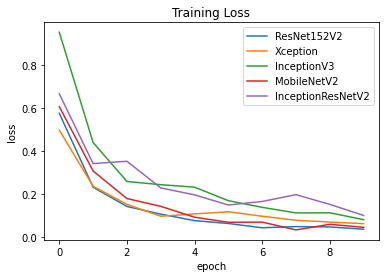

In [ ]:
# summarize history for loss
plt.plot(hist_resnet.history['loss'])
plt.plot(hist_xception.history['loss'])
plt.plot(hist_inception.history['loss'])
plt.plot(hist_mobilenet.history['loss'])
plt.plot(hist_inceptionresnet.history['loss'])

plt.title('Training Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['ResNet152V2', 'Xception', 'InceptionV3', 'MobileNetV2', 'InceptionResNetV2'], loc='upper right')
plt.show()

# Plot training accuracy

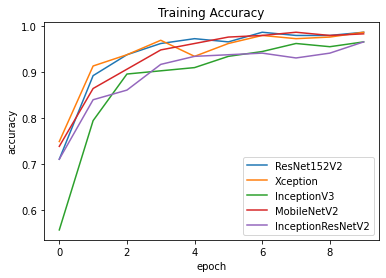

In [ ]:
plt.plot(hist_resnet.history['accuracy'])
plt.plot(hist_xception.history['accuracy'])
plt.plot(hist_inception.history['accuracy'])
plt.plot(hist_mobilenet.history['accuracy'])
plt.plot(hist_inceptionresnet.history['accuracy'])

plt.title('Training Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['ResNet152V2', 'Xception', 'InceptionV3', 'MobileNetV2', 'InceptionResNetV2'], loc='lower right')
plt.show()

# Prediction by the best model (MobileNet)

In [ ]:
def show_image(image, title=None):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

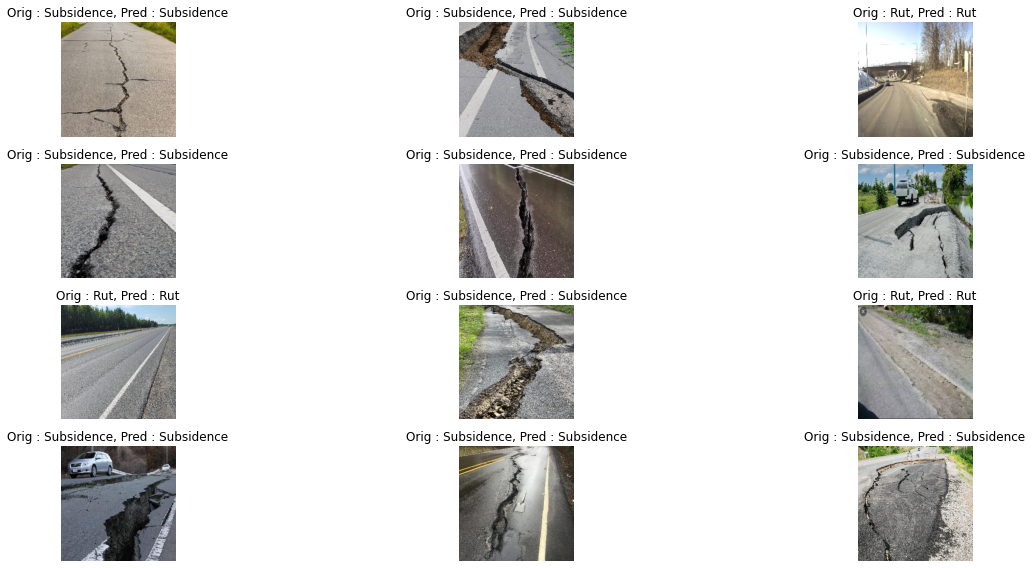

In [ ]:
i=1
plt.figure(figsize=(20,8))
for images, labels in test_ds:
    index = np.random.randint(len(images))
    image, label = images[index], class_names[int(labels[index])]
    pred_label = class_names[np.argmax(model_mobilenet.predict(image[np.newaxis, ...]))]

    plt.subplot(4,3, i)
    show_image(image, title=f"Orig : {label}, Pred : {pred_label}")
    i+=1
    if i>=13: break

plt.tight_layout()
plt.show()

# Reference/s
* Face Mask Detection with Empirical Attention: https://www.kaggle.com/code/chandlertimm/face-mask-detection-with-empirical-attention/notebook#Split-the-data-to-train-and-test
* Shoe-Sandal-Boot Classifier: https://www.kaggle.com/code/utkarshsaxenadn/shoe-sandal-boot-classifier-resnet152v2-acc-97/notebook